In [1]:
import pandas as pd

porosity_df = pd.read_csv('linear_dependency.csv')

In [4]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as mse

import numpy as np

In [12]:
x = porosity_df['d_param'].values.reshape(-1,1)
y = porosity_df['porosity_Gyroid'].values
x.shape

(20, 1)

In [28]:
degree = 3

x_poly = PolynomialFeatures(degree=degree).fit_transform(x)
print(x_poly.shape)
linear = LinearRegression()
linear.fit(x_poly, y)
y_pred = linear.predict(x_poly)
mse(y, y_pred)

(20, 4)


0.0002957161392651706

In [29]:
import matplotlib.pyplot as plt

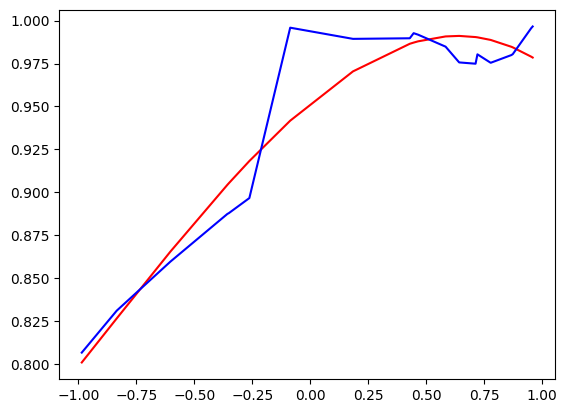

In [30]:
plt.plot(x, y_pred, c='red')
plt.plot(x, y, c='blue')